In [1]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pycocotools.coco import COCO
import fiftyone as fo
import fiftyone.utils.coco as fouc
import json
# from torchmetrics.detection.precision_recall import Precision, Recall

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    df['image_path'] = df['Country'].apply(lambda x: "RDD2022/" + x + "/train/images/")
    df['image_path'] = df['image_path'] + df['Filename'] + '.jpg'
    df['annotation_path'] = df['Country'].apply(lambda x: "RDD2022/" + x + "/train/annotations/xmls/")
    df['annotation_path'] = df['annotation_path'] + df['Filename'] + '.xml'
    return df

def check_valid_bboxes(df):
    image_list = list(train_list['image_path'])
    annotation_list = list(train_list['annotation_path'])
    
    invalid_bboxes = []

    for i in range(len(annotation_list)):
        annotation_path = annotation_list[i]
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            label = 1 if obj.find('name').text in ['D00', 'D10', 'D20', 'D40', 'D43', 'D44', 'D50', 'Repair'] else 0
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            if xmin == xmax or ymin == ymax:
                invalid_bboxes.append(i)
    
    new_df = df.loc[~df.index.isin(invalid_bboxes)]
    return new_df

def get_image_annotation(df):
    return list(df['image_path']), list(df['annotation_path'])

In [3]:
train_list = read_data('RDD2022/train.csv')
train_list = check_valid_bboxes(train_list)
train_image_list, train_annotation_list = get_image_annotation(train_list)

validation_list = read_data('RDD2022/validation.csv')
validation_list = check_valid_bboxes(validation_list)
validation_image_list, validation_annotation_list = get_image_annotation(validation_list)

test_list = read_data('RDD2022/test.csv')
test_list = check_valid_bboxes(test_list)
test_image_list, test_annotation_list = get_image_annotation(test_list)

In [4]:
class_to_idx = {'D00':1, 'D10':2, 'D20':3, 'D40': 4, 'D43': 5, 'D44': 6, 'D50': 7, 'Repair': 8}
idx_to_class = {1: 'D00', 2: 'D10', 3: 'D20', 4: 'D40', 5: 'D43', 6: 'D44', 7: 'D50', 8: 'Repair'}

In [5]:
class PotholeDataset(Dataset):
    def __init__(self, image_list, annotation_list, class_to_idx, transform=None):
        self.image_list = image_list
        self.annotation_list = annotation_list
        self.class_to_idx = class_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        annotation_path = self.annotation_list[idx]
        
        image = Image.open(img_path).convert("RGB")
        if os.path.exists(annotation_path):
            boxes, labels = self._get_annotations(annotation_path)
        else:
            boxes, labels = [], []
        
        if len(boxes) == 0:
            boxes = [[0.0, 0.0, 1.0, 1.0]]
            labels = [0]  # Background class

        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)
        }
        
        return image, target
    
    def _get_annotations(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            label = self.class_to_idx[class_name]
            labels.append(label)
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes, labels

# Transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = PotholeDataset(train_image_list, train_annotation_list, class_to_idx, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [17]:
# torch.save(model.state_dict(), 'faster_rcnn_model_9_classes.pth')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = len(class_to_idx) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('faster_rcnn_model_9_classes.pth', map_location=device))

num_classes = len(class_to_idx) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.12)
    
    train_loss_history = []
    val_loss_history = []
    precision_history = []
    recall_history = []
    map50_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
        
        lr_scheduler.step()
        train_loss = epoch_loss / len(train_loader)
        train_loss_history.append(train_loss)
        
        print(f"Epoch {epoch+1}, Loss: {train_loss}")
        
        val_loss, precision, recall, map50 = validate_model(model, val_loader)
        val_loss_history.append(val_loss)
        precision_history.append(precision)
        recall_history.append(recall)
        map50_history.append(map50)
    
    print("Training completed.")
    return train_loss_history, val_loss_history, precision_history, recall_history, map50_history


def validate_model(model, validation_loader):
    model.eval()
    val_loss = 0
    map_metric = MeanAveragePrecision(iou_thresholds=[0.5])
    precision_metric = Precision(iou_threshold=0.5)
    recall_metric = Recall(iou_threshold=0.5)
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

            # Convert predictions to the format required by the metrics
            for target, prediction in zip(targets, predictions):
                preds = {
                    'boxes': prediction['boxes'].cpu(),
                    'scores': prediction['scores'].cpu(),
                    'labels': prediction['labels'].cpu()
                }
                gt = {
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                }
                map_metric.update([preds], [gt])
                precision_metric.update([preds], [gt])
                recall_metric.update([preds], [gt])
        
        # Compute metrics
        map_results = map_metric.compute()
        precision = precision_metric.compute()
        recall = recall_metric.compute()
        mAP = map_results['map']
        
    val_loss /= len(validation_loader)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation mAP: {mAP}")
    print(f"Validation Precision: {precision}")
    print(f"Validation Recall: {recall}")
    
    return val_loss, precision, recall, mAP


validation_dataset = PotholeDataset(validation_image_list, validation_annotation_list, class_to_idx, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Train the model with validation
train_model(model, train_loader, num_epochs=15)

Epoch 1, Loss: 0.34938059621913864
Epoch 2, Loss: 0.2990359733431515
Epoch 3, Loss: 0.2807495707180351
Epoch 4, Loss: 0.25200457425407047
Epoch 5, Loss: 0.24597777176267382
Epoch 6, Loss: 0.2413498382295736
Epoch 7, Loss: 0.2345164799787612
Epoch 8, Loss: 0.23392114163884384
Epoch 9, Loss: 0.23269184707579288
Epoch 10, Loss: 0.2317431790203872
Epoch 11, Loss: 0.2316838907458904
Epoch 12, Loss: 0.23159344272095372
Epoch 13, Loss: 0.23166337020017885
Epoch 14, Loss: 0.23143765502609312
Epoch 15, Loss: 0.23156249687414276
{'loss_classifier': tensor(0.1135, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2043, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0205, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>)}
Training completed.


In [6]:
# torch.save(model.state_dict(), 'faster_rcnn_model_9_classes.pth')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = len(class_to_idx) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.load_state_dict(torch.load('faster_rcnn_model_9_classes.pth', map_location=device))

model = model.to(device)

In [7]:
test_dataset = PotholeDataset(test_image_list, test_annotation_list, class_to_idx, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model.eval()
val_loss = 0
# metric = MeanAveragePrecision(iou_thresholds=[0.5])

prediction_test = []
actual_test = []
for images, targets in test_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)

        # Convert predictions to the format required by MeanAveragePrecision metric
#         metric_inputs = []
        for target, prediction in zip(targets, predictions):
            preds = {
                'boxes': prediction['boxes'].cpu(),
                'scores': prediction['scores'].cpu(),
                'labels': prediction['labels'].cpu()
            }
            gt = {
                'boxes': target['boxes'].cpu(),
                'labels': target['labels'].cpu()
            }
            prediction_test.append(preds)
            actual_test.append(gt)

In [11]:
prediction_test[0]

{'boxes': tensor([[114.9448,  91.2748, 136.6242, 108.7262],
         [  0.0000, 207.7803, 512.0000, 427.9255],
         [  0.0000, 102.8161, 501.3917, 367.9528],
         [  8.1229, 219.4803, 506.3166, 439.0305],
         [ 26.3294, 218.7202, 507.5566, 425.3928],
         [120.5061,  92.7899, 136.7246, 103.9223]]),
 'scores': tensor([0.9381, 0.5608, 0.2331, 0.1361, 0.0804, 0.0749]),
 'labels': tensor([4, 8, 8, 6, 5, 4])}

In [12]:
actual_test[0]

{'boxes': tensor([[115.,  93., 137., 109.],
         [  1., 137., 511., 419.]]),
 'labels': tensor([4, 8])}

## Calculating metrics

In [285]:
test_matches = []
test_fp_labels = []
predicted_threshold = []
for i in range(len(prediction_test)):
    predicted = prediction_test[i]
    
    threshold = 0.5
    keep_indices = predicted['scores'] >= threshold
    filtered_boxes = predicted['boxes'][keep_indices]
    filtered_scores = predicted['scores'][keep_indices]
    filtered_labels = predicted['labels'][keep_indices]
    predicted = {
        'boxes': filtered_boxes,
        'scores': filtered_scores,
        'labels': filtered_labels
    }
    predicted_threshold.extend([predicted])

In [287]:
actual = actual_test
predicted = predicted_threshold

In [288]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

def match_detections(predictions, ground_truths, iou_threshold=0.5):
    matches = []
    for pred_idx, (pred_box, pred_label, pred_score) in enumerate(zip(predictions['boxes'], predictions['labels'], predictions['scores'])):
        best_iou = 0
        best_match = -1
        for gt_idx, (gt_box, gt_label) in enumerate(zip(ground_truths['boxes'], ground_truths['labels'])):
            if pred_label == gt_label:
                iou = calculate_iou(pred_box.numpy(), gt_box.numpy())
                if iou > best_iou:
                    best_iou = iou
                    best_match = gt_idx
        
        if best_iou >= iou_threshold:
            matches.append((best_match, pred_idx))
        else:
            matches.append((-1, pred_idx))
    
    return matches

def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

# Initialize counters for overall metrics
overall_tp = 0
overall_fp = 0
overall_fn = 0

# Initialize counters for class-wise metrics
class_tp = defaultdict(int)
class_fp = defaultdict(int)
class_fn = defaultdict(int)

for gt, pred in zip(actual, predicted):
    matches = match_detections(pred, gt)
    
    matched_gt_indices = set()
    for gt_idx, pred_idx in matches:
        if gt_idx != -1:
            matched_gt_indices.add(gt_idx)
            if gt['labels'][gt_idx].item() == pred['labels'][pred_idx].item():
                overall_tp += 1
                class_tp[gt['labels'][gt_idx].item()] += 1
            else:
                overall_fp += 1
                class_fp[pred['labels'][pred_idx].item()] += 1
        else:
            overall_fp += 1
            class_fp[pred['labels'][pred_idx].item()] += 1
    
    for gt_idx, gt_label in enumerate(gt['labels']):
        if gt_idx not in matched_gt_indices:
            overall_fn += 1
            class_fn[gt_label.item()] += 1

# Calculate overall metrics
overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_tp, overall_fp, overall_fn)

# Calculate class-wise metrics
class_metrics = {}
for class_id in class_to_idx.values():
    tp = class_tp[class_id]
    fp = class_fp[class_id]
    fn = class_fn[class_id]
    precision, recall, f1 = calculate_metrics(tp, fp, fn)
    class_metrics[class_id] = {'precision': precision, 'recall': recall, 'f1': f1}

# Calculate mAP50
def calculate_map50(actual, predicted, class_to_idx, iou_threshold=0.5):
    ap_per_class = {}
    for class_id in class_to_idx.values():
        tp = []
        fp = []
        scores = []
        total_gt = 0

        for gt, pred in zip(actual, predicted):
            gt_boxes = [gt['boxes'][i] for i in range(len(gt['labels'])) if gt['labels'][i].item() == class_id]
            pred_boxes = [(pred['boxes'][i], pred['scores'][i]) for i in range(len(pred['labels'])) if pred['labels'][i].item() == class_id]

            total_gt += len(gt_boxes)
            if len(pred_boxes) == 0:
                continue

            pred_boxes = sorted(pred_boxes, key=lambda x: x[1], reverse=True)
            matched_gt = set()
            for pred_box, score in pred_boxes:
                best_iou = 0
                best_gt_idx = -1
                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx not in matched_gt:
                        iou = calculate_iou(pred_box.numpy(), gt_box.numpy())
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                if best_iou >= iou_threshold:
                    tp.append(1)
                    fp.append(0)
                    matched_gt.add(best_gt_idx)
                else:
                    tp.append(0)
                    fp.append(1)
                scores.append(score.item())

        if len(tp) == 0:
            ap_per_class[class_id] = 0
            continue

        tp = np.array(tp)
        fp = np.array(fp)
        scores = np.array(scores)

        indices = np.argsort(-scores)
        tp = tp[indices]
        fp = fp[indices]

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
        recalls = tp_cumsum / total_gt

        precisions = np.concatenate(([1], precisions))
        recalls = np.concatenate(([0], recalls))

        ap = 0
        for i in range(1, len(precisions)):
            ap += (recalls[i] - recalls[i - 1]) * precisions[i]
        ap_per_class[class_id] = ap

    mAP50 = np.mean(list(ap_per_class.values()))
    return mAP50, ap_per_class

# Calculate mAP50
mAP50, ap_per_class = calculate_map50(actual, predicted, class_to_idx)

# Print overall metrics
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")
print(f"Overall mAP50: {mAP50}")

# Print class-wise metrics
for class_id, metrics in class_metrics.items():
    print(f"Class {idx_to_class[class_id]} - Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1 Score: {metrics['f1']}")

# Print class-wise AP50
for class_id, ap in ap_per_class.items():
    print(f"Class {idx_to_class[class_id]} - AP50: {ap}")


Overall Precision: 0.47231807951988
Overall Recall: 0.6929341844596082
Overall F1 Score: 0.5617416131334761
Overall mAP50: 0.6191938276109525
Class D00 - Precision: 0.46888320545609546, Recall: 0.7323568575233023, F1 Score: 0.5717255717255717
Class D10 - Precision: 0.3885180240320427, Recall: 0.6847058823529412, F1 Score: 0.4957410562180579
Class D20 - Precision: 0.5245769540692989, Recall: 0.74230330672748, F1 Score: 0.6147308781869689
Class D40 - Precision: 0.43532338308457713, Recall: 0.603448275862069, F1 Score: 0.5057803468208093
Class D43 - Precision: 0.6046511627906976, Recall: 0.8125, F1 Score: 0.6933333333333334
Class D44 - Precision: 0.5032258064516129, Recall: 0.8020565552699229, F1 Score: 0.618434093161546
Class D50 - Precision: 0.581447963800905, Recall: 0.8263665594855305, F1 Score: 0.6826029216467463
Class Repair - Precision: 0.6333333333333333, Recall: 0.7916666666666666, F1 Score: 0.7037037037037038
Class D00 - AP50: 0.5736176162544983
Class D10 - AP50: 0.4818396297046

In [25]:
# final

from sklearn.metrics import precision_recall_fscore_support, classification_report

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection
    
    return intersection / union

def match_boxes(pred_boxes, pred_labels, true_boxes, true_labels, iou_threshold=0.5):
    tp = {i: 0 for i in range(9)}
    fp = {i: 0 for i in range(9)}
    fn = {i: 0 for i in range(9)}
    matched_true_boxes = []

    for i, pred_box in enumerate(pred_boxes):
        pred_label = pred_labels[i].item()
        max_iou = 0
        best_match = -1
        for j, true_box in enumerate(true_boxes):
            if true_labels[j].item() != pred_label:
                continue
            iou = calculate_iou(pred_box, true_box)
            if iou > max_iou:
                max_iou = iou
                best_match = j
        
        if max_iou >= iou_threshold:
            if best_match not in matched_true_boxes:
                tp[pred_label] += 1
                matched_true_boxes.append(best_match)
            else:
                fp[pred_label] += 1
        else:
            fp[pred_label] += 1
    
    for i, true_label in enumerate(true_labels):
        if i not in matched_true_boxes:
            fn[true_label.item()] += 1
    
    return tp, fp, fn

In [48]:
actuals = actual_test
predictions = prediction_test

all_tp = {i: 0 for i in range(9)}
all_fp = {i: 0 for i in range(9)}
all_fn = {i: 0 for i in range(9)}

score_threshold = 0.75

for pred, actual in zip(predictions, actuals):
    # Filter predictions based on score threshold
    filtered_boxes = pred['boxes'][pred['scores'] > score_threshold]
    filtered_labels = pred['labels'][pred['scores'] > score_threshold]
    
    tp, fp, fn = match_boxes(filtered_boxes, filtered_labels, actual['boxes'], actual['labels'], 0.5)
    for key in tp.keys():
        all_tp[key] += tp[key]
        all_fp[key] += fp[key]
        all_fn[key] += fn[key]

metrics = {}
for key in all_tp.keys():
    precision = all_tp[key] / (all_tp[key] + all_fp[key]) if (all_tp[key] + all_fp[key]) > 0 else 0
    recall = all_tp[key] / (all_tp[key] + all_fn[key]) if (all_tp[key] + all_fn[key]) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    metrics[key] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

overall_tp = sum(all_tp.values())
overall_fp = sum(all_fp.values())
overall_fn = sum(all_fn.values())

overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

print("Classification Report:\n")
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
for key, value in metrics.items():
    print(f"{key:<10} {value['precision']:<10.4f} {value['recall']:<10.4f} {value['f1_score']:<10.4f}")

print(f"\n{'Overall':<10} {overall_precision:<10.4f} {overall_recall:<10.4f} {overall_f1_score:<10.4f}")

Classification Report:

Class      Precision  Recall     F1 Score  
0          0.0000     0.0000     0.0000    
1          0.5940     0.6308     0.6118    
2          0.5406     0.5400     0.5403    
3          0.6212     0.6174     0.6193    
4          0.5872     0.4876     0.5328    
5          0.7414     0.6825     0.7107    
6          0.6447     0.7211     0.6807    
7          0.6901     0.7588     0.7228    
8          0.8571     0.5455     0.6667    

Overall    0.6041     0.5854     0.5946    



|Class|      Precision | Recall |    F1 Score|  mAP50 |
| --- | --- | --- | --- | --- |
|D00|          0.5940|     0.6308|     0.6118    |0.5736|
|D10 |         0.5406 |    0.5400 |    0.5403    |0.4818|
|D20  |        0.6212  |   0.6174  |   0.6193    |0.5961|
|D40   |       0.5872   |  0.4876   |  0.5328    |0.4443|
|D43    |      0.7414    | 0.6825    | 0.7107    |0.7409|
|D44     |     0.6447     |0.7211   |  0.6807    |0.6591|
|D50      |    0.6901 |    0.7588    | 0.7228    |0.7557|
|Repair     |   0.8571  |   0.5455     |0.6667    |0.7017|
|Overall  |  0.6041   |  0.5854     |0.5946|0.6191|


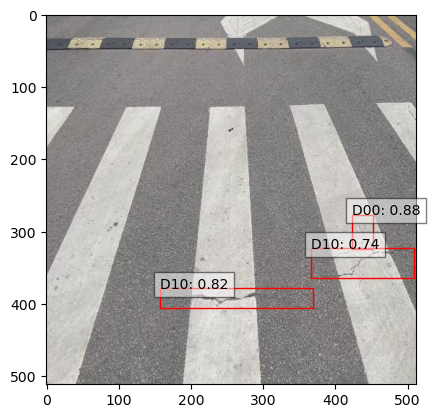

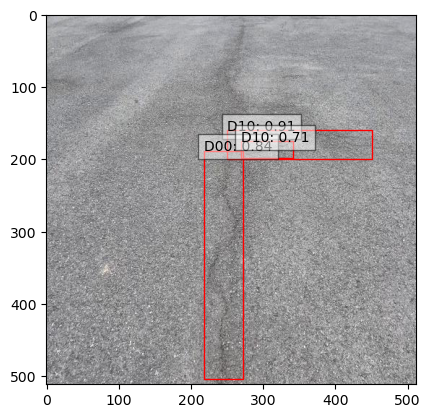

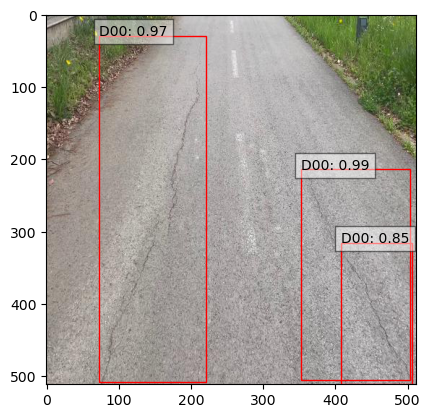

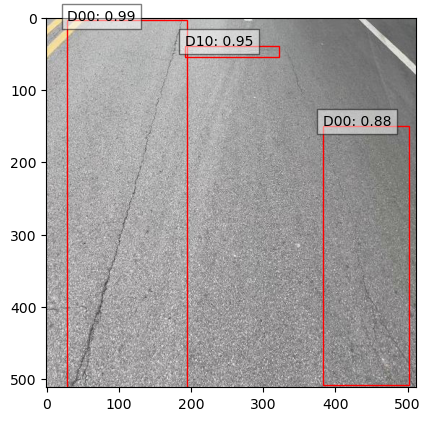

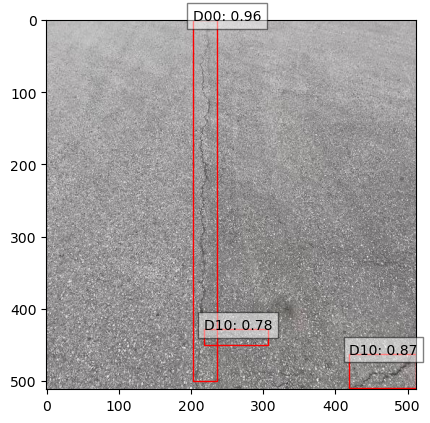

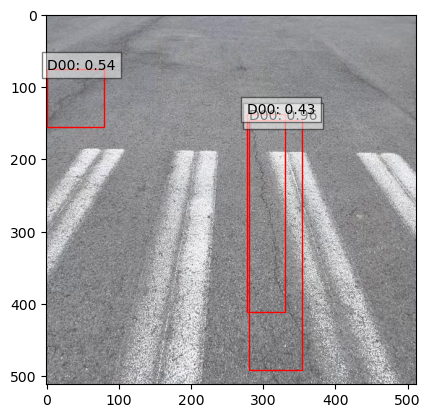

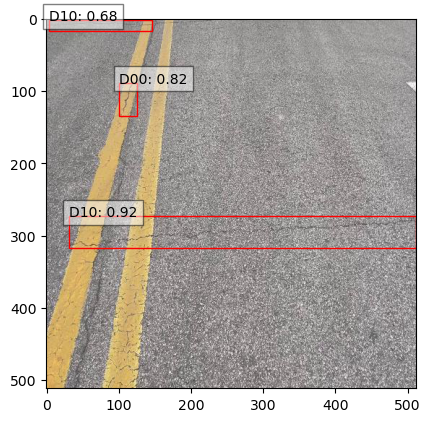

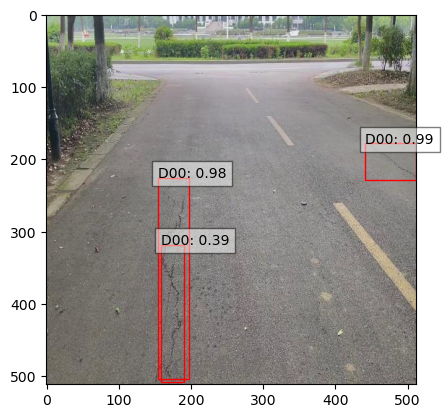

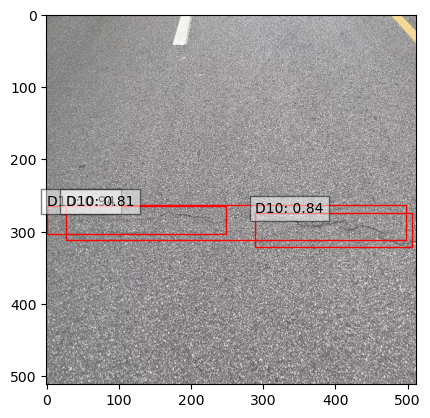

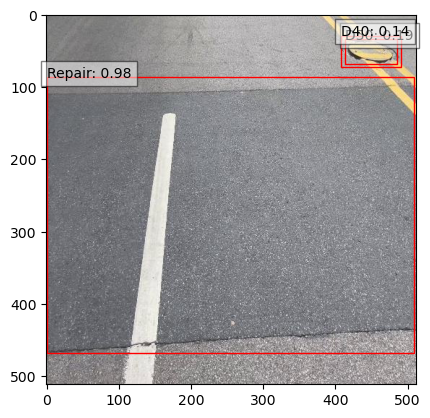

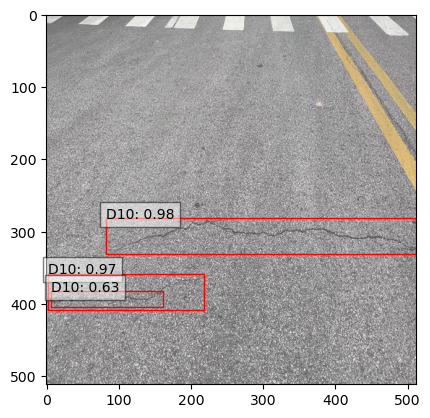

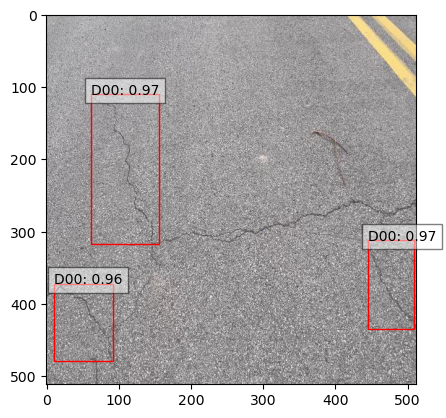

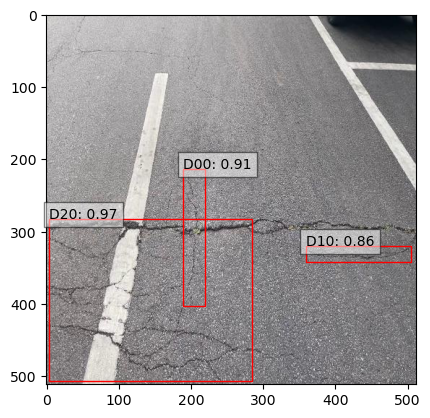

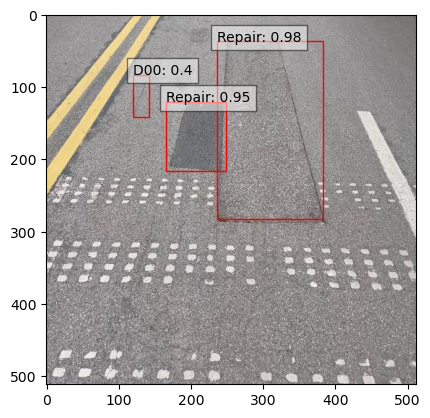

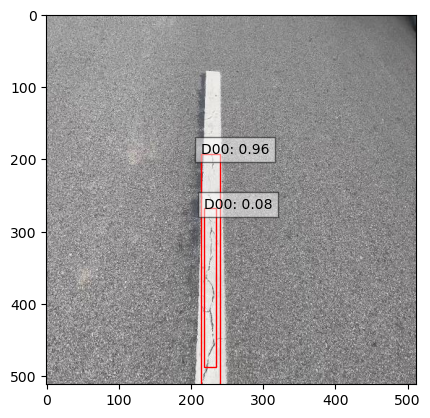

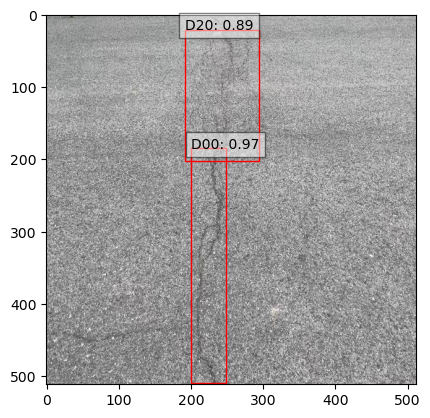

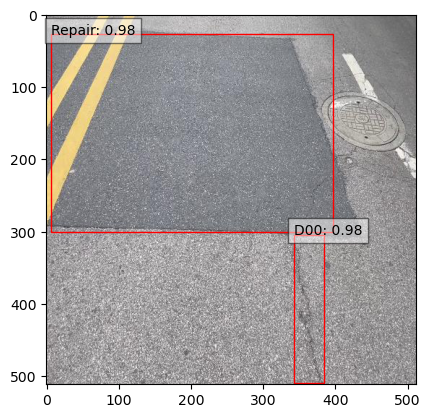

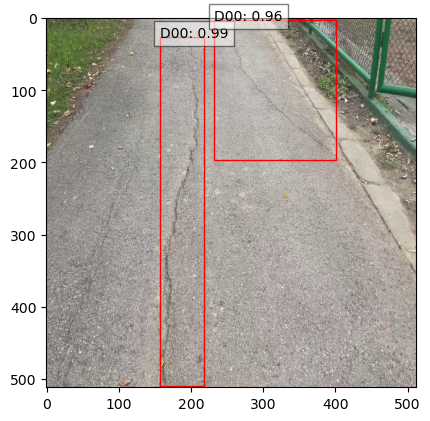

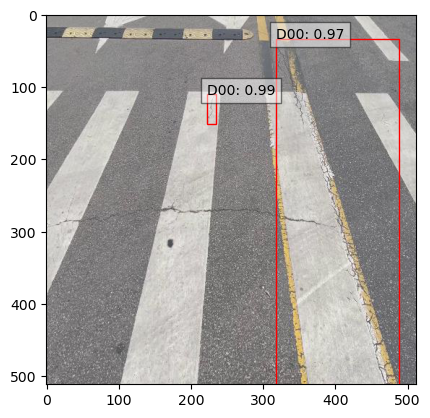

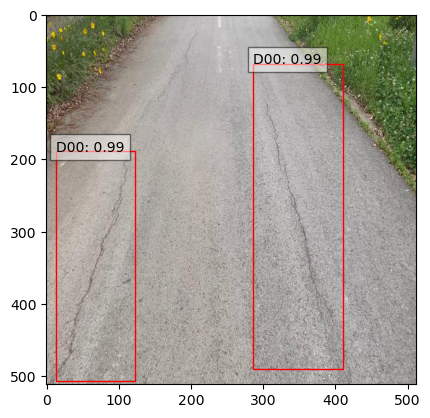

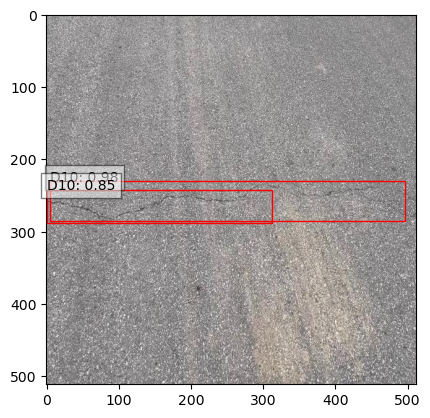

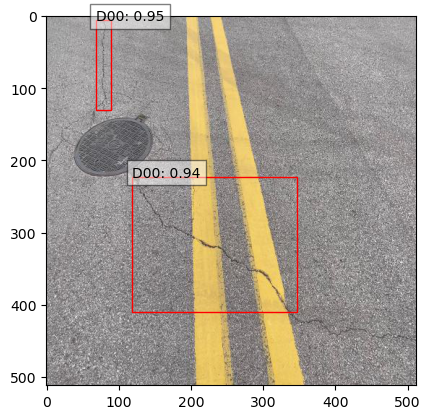

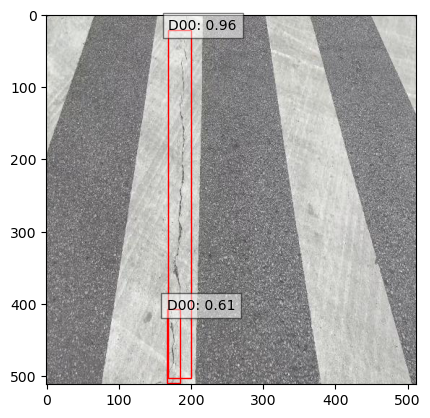

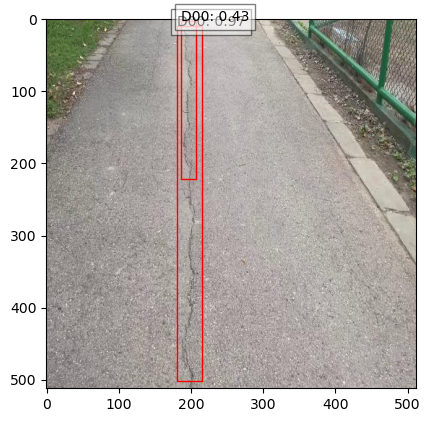

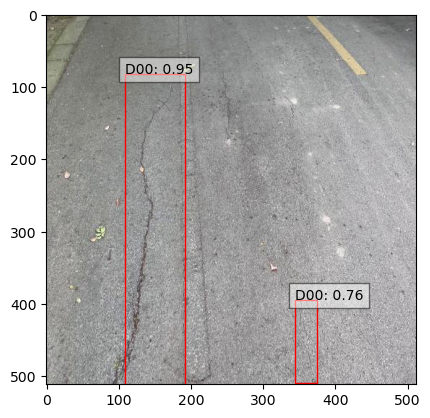

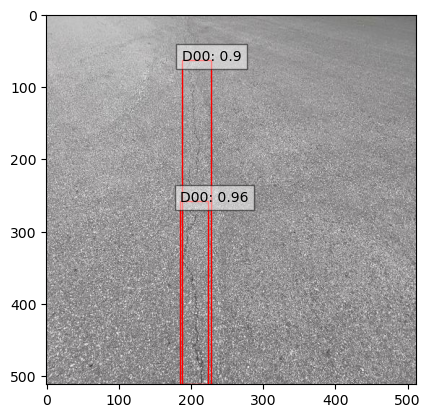

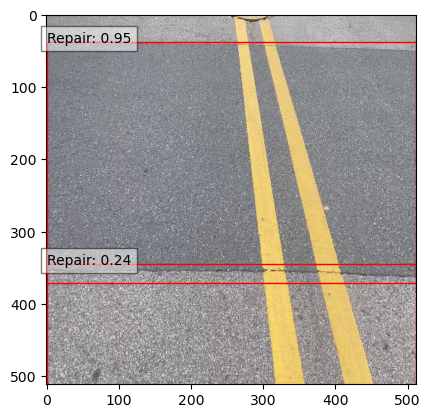

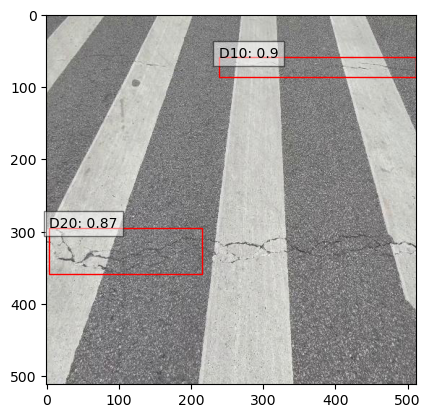

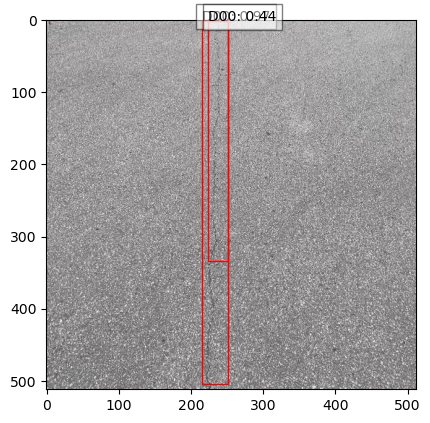

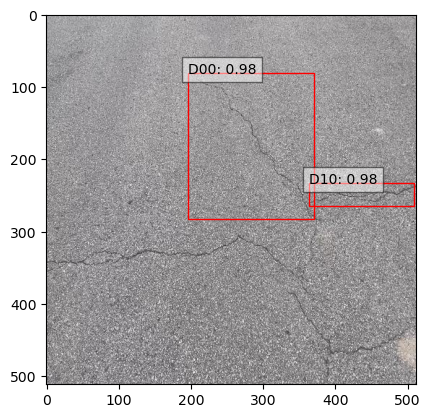

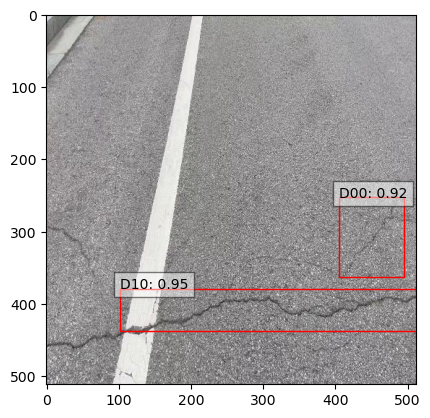

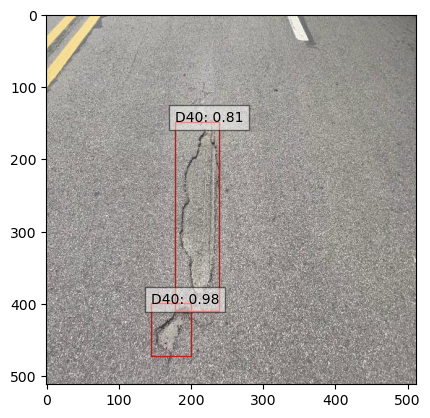

In [226]:
def visualize_predictions(model, data_loader, idx_to_class, top_k=3):
    model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    x = 0
    
    for images, _ in data_loader:
        x += 1
        if x == 5:
            break
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            predictions = model(images)
        
        for i in range(len(images)):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            
            # Get predictions for this image
            boxes = predictions[i]['boxes']
            scores = predictions[i]['scores']
            labels = predictions[i]['labels']
            
            top_k = min(len(scores), top_k)
            
            # Select top_k boxes based on scores
            top_indices = scores.topk(top_k).indices
            
            for idx in top_indices:
                xmin, ymin, xmax, ymax = boxes[idx].cpu().numpy()
                label_idx = labels[idx].item()
                label_name = idx_to_class[label_idx] + ': ' + str(round(scores[idx].item(), 2))
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, label_name, bbox={'facecolor': 'white', 'alpha': 0.5})
            
            plt.show()

# Visualize predictions
visualize_predictions(model, validation_loader, idx_to_class)

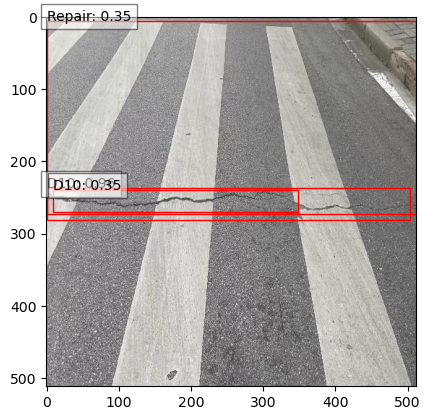

In [263]:
# Function to visualize predictions
def visualize_single_image_predictions(model, image_tensor, idx_to_class, top_k=3):
    model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    # Get predictions for this image
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
#     print(boxes, scores)
    # Select top_k boxes based on scores
    top_k = min(len(scores), top_k)
    top_indices = scores.topk(top_k).indices
    
    for idx in top_indices:
        xmin, ymin, xmax, ymax = boxes[idx].cpu().numpy()
        label_idx = labels[idx].item()
        label_name = idx_to_class[label_idx] + ': ' + str(round(scores[idx].item(), 2))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, label_name, bbox={'facecolor': 'white', 'alpha': 0.5})
            
    
    plt.show()

preprocess = transforms.Compose([
    transforms.ToTensor()
])

# Load the image
image_path = 'RDD2022/China_MotorBike/train/images/China_MotorBike_00131.jpg'
image = Image.open(image_path).convert("RGB")

# Preprocess the image
image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

visualize_single_image_predictions(model, image_tensor, idx_to_class)